In [6]:
from skimage import io
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [7]:
def Kuwahara(original, winsize):
    image = original.astype(np.float64)
    # make sure window size is correct
    if winsize %4 != 1:
        raise Exception ("Invalid winsize %s: winsize must follow formula: w = 4*n+1." %winsize)

    #Build subwindows(三角形朝下)
    tmpavgker = np.ones(winsize)
    for i in range(1,winsize//2+1):
        tmpavgKerRow = np.hstack((np.zeros((1,i)),np.ones((1,winsize-i*2)),np.zeros((1,i))))
        tmpavgker = np.vstack((tmpavgker,tmpavgKerRow))
    tmpPadder = np.zeros(winsize)
    tmpavgker = np.vstack((tmpavgker, np.tile(tmpPadder, ((winsize-1)//2,1))))
    #平均濾波遮罩
    tmpavgker = tmpavgker/np.sum(tmpavgker)

    # tmpavgker is a 'north-west' subwindow (marked as 'a' above)
    # we build a vector of convolution kernels for computing average and
    # variance
    avgker = np.empty((4,winsize,winsize)) # make an empty vector of arrays
    avgker[0] = tmpavgker               # North (a)
    avgker[1] = np.rot90(tmpavgker,3)   # East (b)
    avgker[2] = np.flipud(tmpavgker)    # South (c)
    avgker[3] = np.fliplr(avgker[1])    # West (d)

    # Create a pixel-by-pixel square of the image
    squaredImg = image**2
   # preallocate these arrays to make it apparently %15 faster
    avgs = np.zeros([4, image.shape[0],image.shape[1]])
    stddevs = avgs.copy()

    # Calculation of averages and variances on subwindows
    for k in range(4):
        # mean on subwindow(期望值)
        avgs[k] = convolve2d(image, avgker[k],mode='same')
        # mean of squares on subwindow(平方的期望值)
        stddevs[k] = convolve2d(squaredImg, avgker[k],mode='same')
        # variance on subwindow(算變異數:平方的平均-平均的平方)
        stddevs[k] = stddevs[k]-avgs[k]**2
   # Choice of index with minimum variance
    indices = np.argmin(stddevs,0) # returns index of subwindow with smallest variance

    # Building the filtered image (with nested for loops)
    filtered = np.zeros(original.shape)
    for row in range(original.shape[0]):
        for col in range(original.shape[1]):
            filtered[row,col] = avgs[indices[row,col], row,col]

    #filtered=filtered.astype(np.uint8)
    return filtered.astype(np.uint8)

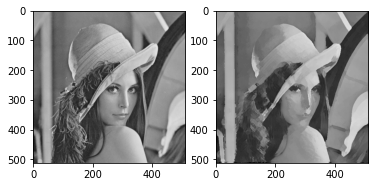

In [8]:
c = io.imread('lena512gray.jpg')

cK=Kuwahara(c,13)


fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

ax1.imshow(c/255,vmax=1.0,vmin=0.0)
ax2.imshow(cK/255,vmax=1.0,vmin=0.0)

plt.show()
